# Urgency Dataset

In [2]:
import pandas as pd

df = pd.read_csv("../UrgencySentenceSamples.csv", encoding="utf-8") 
ohe = pd.get_dummies(df["Label"])
df = pd.concat([df["Sentence"], ohe], axis=1)
df.head(5)

,Sentence,critical,info,warning
0,As of today 60 people went missing on the park,1,0,0
1,The biker was injured on the street and now is...,1,0,0
2,The president has been kidnapped by terrorists,1,0,0
3,People in Louisiana are in dire need of food a...,1,0,0
4,Five cars were hit and are now stranded beneat...,1,0,0


In [3]:
#import nltk and clean the corpus
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk 

lines = df['Sentence'].values.tolist()

nltk.download('punkt')
nltk.download('stopwords')

def text_normalization(lines):
    sentences = list()
    for line in lines:   
        tokens = word_tokenize(line)
        # convert to lower case
        tokens = [w.lower() for w in tokens]
        # remove punctuation from each word    
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove remaining tokens that are not alphabetic
        words = [word for word in stripped if word.isalpha()]
        # filter out stop words    
        stop_words = set(stopwords.words('english'))
        words = [w for w in words if not w in stop_words]
        sentences.append(words)
    return sentences

sentences = text_normalization(lines)

[nltk_data] Downloading package punkt to /Users/aszeto1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aszeto1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
print(sentences[0])

['today', 'people', 'went', 'missing', 'park']


In [5]:
#import data processing libraries
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [6]:
#load glove embedding
embeddings_dict = {}

with open('glove.6B/glove.6B.50d.txt', 'r', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [7]:
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

VALIDATION_SPLIT = 0.10
max_length = 100

# vectorize the text samples into a 2D integer tensor
tokenizer_obj = Tokenizer() 
tokenizer_obj.fit_on_texts(sentences)
sequences = tokenizer_obj.texts_to_sequences(sentences)

# pad sequences
word_index = tokenizer_obj.word_index
print('Found %s unique tokens.' % len(word_index))


review_pad = pad_sequences(sequences, maxlen=max_length)

urgency = np.array((df['critical'].values, df['warning'].values, df['info'].values)).T
print('Shape of review tensor:', review_pad.shape)
print('Shape of urgency tensor:', urgency.shape)

# split the data into a training set and a validation set
indices = np.arange(review_pad.shape[0])
np.random.shuffle(indices)
review_pad = review_pad[indices]
urgency = urgency[indices]
num_validation_samples = int(VALIDATION_SPLIT * review_pad.shape[0])


X_train_pad = review_pad[:-num_validation_samples]
y_train = urgency[:-num_validation_samples]
X_test_pad = review_pad[-num_validation_samples:]
y_test = urgency[-num_validation_samples:]

Found 157 unique tokens.
Shape of review tensor: (44, 100)
Shape of urgency tensor: (44, 3)


In [8]:
X_train_pad[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   5, 148,   3, 149], dtype=int32)

In [9]:
#set up embedding matrix
EMBEDDING_DIM =50
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_dict.get(word)
  
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


In [10]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from tensorflow.keras.layers import Embedding
from keras.initializers import Constant

# define model
model = Sequential()
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_length,
                            trainable=False)
model.add(embedding_layer)
model.add(LSTM(units=32,  dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Summary of the built model...')
print(model.summary())

# fit the model
history = model.fit(X_train_pad, y_train, batch_size=1, epochs=25, validation_data=(X_test_pad, y_test), verbose=2)


2023-03-02 22:19:40.114981: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Summary of the built model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           7900      
                                                                 
 lstm (LSTM)                 (None, 32)                10624     
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 18,623
Trainable params: 10,723
Non-trainable params: 7,900
_________________________________________________________________
None
Epoch 1/25


2023-03-02 22:19:44.198081: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


40/40 - 3s - loss: 1.0811 - accuracy: 0.5000 - val_loss: 1.0736 - val_accuracy: 0.5000 - 3s/epoch - 71ms/step
Epoch 2/25
40/40 - 1s - loss: 0.9566 - accuracy: 0.6500 - val_loss: 0.9907 - val_accuracy: 0.7500 - 1s/epoch - 29ms/step
Epoch 3/25
40/40 - 1s - loss: 0.8467 - accuracy: 0.7250 - val_loss: 0.8898 - val_accuracy: 0.7500 - 1s/epoch - 27ms/step
Epoch 4/25
40/40 - 1s - loss: 0.7610 - accuracy: 0.7750 - val_loss: 0.8081 - val_accuracy: 0.7500 - 1s/epoch - 27ms/step
Epoch 5/25
40/40 - 1s - loss: 0.6542 - accuracy: 0.8250 - val_loss: 0.7153 - val_accuracy: 0.7500 - 1s/epoch - 26ms/step
Epoch 6/25
40/40 - 1s - loss: 0.5572 - accuracy: 0.9000 - val_loss: 0.5891 - val_accuracy: 0.7500 - 1s/epoch - 26ms/step
Epoch 7/25
40/40 - 1s - loss: 0.5029 - accuracy: 0.8250 - val_loss: 0.4410 - val_accuracy: 0.7500 - 1s/epoch - 26ms/step
Epoch 8/25
40/40 - 1s - loss: 0.3653 - accuracy: 0.9250 - val_loss: 0.3571 - val_accuracy: 1.0000 - 1s/epoch - 26ms/step
Epoch 9/25
40/40 - 1s - loss: 0.3476 - accu

In [11]:
#save model into remote filesystem
model.save('model')

INFO:tensorflow:Assets written to: model/assets


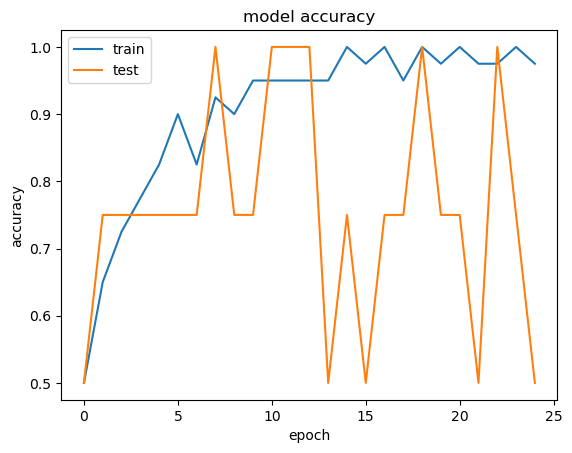

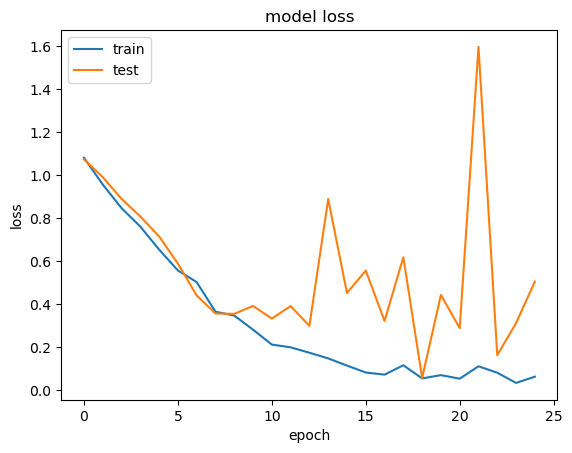

In [12]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
test = "I need to buy a bike very soon" 
test = "I am in critical danger or starving to death"
test = "My brother is named Jeremy"


tokens = word_tokenize(test)
# convert to lower case
tokens = [w.lower() for w in tokens]
# remove punctuation from each word    
table = str.maketrans('', '', string.punctuation)
stripped = [w.translate(table) for w in tokens]
# remove remaining tokens that are not alphabetic
words = [word for word in stripped if word.isalpha()]
# filter out stop words    
stop_words = set(stopwords.words('english'))
words = [w for w in words if not w in stop_words]


sequences = tokenizer_obj.texts_to_sequences([words])


review_pad = pad_sequences(sequences, maxlen=max_length)

encoding = ["critical", "warning", "info"]
probabilities = model.predict(review_pad)
prediction = np.argmax(probabilities)

print('Sentence being analyzed by the model: ', test)
print(f'Prediction: {encoding[prediction]} with probability {probabilities[0][prediction] * 100}%')

1/1 [==============================] - 0s 234ms/step
Sentence being analyzed by the model:  My brother is named Jeremy
Prediction: info with probability 60.899680852890015%


# Ecommerce Dataset

In [33]:
# Load the dataset
dataset = "../ecommerceDataset.csv"
data = pd.read_csv(dataset, names=["label", "description"])
data = data[["description", "label"]]

# Clean the data - drop duplicates and missing values
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)

# One hot encoding
ohe = pd.get_dummies(data["label"])
data = pd.concat([data["description"], ohe], axis=1)

data

,description,Books,Clothing & Accessories,Electronics,Household
0,Paper Plane Design Framed Wall Hanging Motivat...,0,0,0,1
1,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",0,0,0,1
2,SAF 'UV Textured Modern Art Print Framed' Pain...,0,0,0,1
3,"SAF Flower Print Framed Painting (Synthetic, 1...",0,0,0,1
4,Incredible Gifts India Wooden Happy Birthday U...,0,0,0,1
...,...,...,...,...,...
27797,Micromax Bharat 5 Plus Zero impact on visual d...,0,0,1,0
27798,Microsoft Lumia 550 8GB 4G Black Microsoft lum...,0,0,1,0
27799,"Microsoft Lumia 535 (Black, 8GB) Colour:Black ...",0,0,1,0
27800,Karbonn Titanium Wind W4 (White) Karbonn Titan...,0,0,1,0


In [34]:
# Text normalization
lines = data['description'].values.tolist()
ecommerce_sentences = text_normalization(lines)
print(ecommerce_sentences[0])

['paper', 'plane', 'design', 'framed', 'wall', 'hanging', 'motivational', 'office', 'decor', 'art', 'prints', 'x', 'inch', 'set', 'painting', 'made', 'synthetic', 'frame', 'uv', 'textured', 'print', 'gives', 'multi', 'effects', 'attracts', 'towards', 'special', 'series', 'paintings', 'makes', 'wall', 'beautiful', 'gives', 'royal', 'touch', 'painting', 'ready', 'hang', 'would', 'proud', 'possess', 'unique', 'painting', 'niche', 'apart', 'use', 'modern', 'efficient', 'printing', 'technology', 'prints', 'inks', 'precision', 'epson', 'roland', 'hp', 'printers', 'innovative', 'hd', 'printing', 'technique', 'results', 'durable', 'spectacular', 'looking', 'prints', 'highest', 'last', 'lifetime', 'print', 'solely', 'topnotch', 'inks', 'achieve', 'brilliant', 'true', 'colours', 'due', 'high', 'level', 'uv', 'resistance', 'prints', 'retain', 'beautiful', 'colours', 'many', 'years', 'add', 'colour', 'style', 'living', 'space', 'digitally', 'printed', 'painting', 'pleasure', 'eternal', 'blissso', 

In [35]:
VALIDATION_SPLIT = 0.20
max_length = 1000

# vectorize the text samples into a 2D integer tensor
tokenizer_obj = Tokenizer() 
tokenizer_obj.fit_on_texts(ecommerce_sentences)
ecommerce_sequences = tokenizer_obj.texts_to_sequences(ecommerce_sentences)

# pad sequences
word_index = tokenizer_obj.word_index
print('Found %s unique tokens.' % len(word_index))

review_pad = pad_sequences(ecommerce_sequences, maxlen=max_length)

urgency = np.array((data['Books'].values, data['Clothing & Accessories'].values, data['Electronics'].values, data['Household'].values)).T
print('Shape of review tensor:', review_pad.shape)
print('Shape of urgency tensor:', urgency.shape)

# split the data into a training set and a validation set
indices = np.arange(review_pad.shape[0])
np.random.shuffle(indices)
review_pad = review_pad[indices]
urgency = urgency[indices]
num_validation_samples = int(VALIDATION_SPLIT * review_pad.shape[0])


X_train_pad = review_pad[:-num_validation_samples]
y_train = urgency[:-num_validation_samples]
X_test_pad = review_pad[-num_validation_samples:]
y_test = urgency[-num_validation_samples:]

X_train_pad[0]

Found 78711 unique tokens.
Shape of review tensor: (27802, 1000)
Shape of urgency tensor: (27802, 4)


array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [36]:
#set up embedding matrix
EMBEDDING_DIM = 50
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_dict.get(word)
  
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


In [38]:
# define model
ecommerce_model = Sequential()
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_length,
                            trainable=False)
ecommerce_model.add(embedding_layer)
ecommerce_model.add(LSTM(units=32,  dropout=0.2, recurrent_dropout=0.2))
ecommerce_model.add(Dense(4, activation='softmax'))

# try using different optimizers and different optimizer configs
ecommerce_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Summary of the built model...')
print(ecommerce_model.summary())

# fit the model
history = ecommerce_model.fit(X_train_pad, y_train, batch_size=100, epochs=40, validation_data=(X_test_pad, y_test), verbose=2)


Summary of the built model...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1000, 50)          3935600   
                                                                 
 lstm_3 (LSTM)               (None, 32)                10624     
                                                                 
 dense_3 (Dense)             (None, 4)                 132       
                                                                 
Total params: 3,946,356
Trainable params: 10,756
Non-trainable params: 3,935,600
_________________________________________________________________
None
Epoch 1/40
223/223 - 172s - loss: 0.6007 - accuracy: 0.8008 - val_loss: 0.3707 - val_accuracy: 0.8969 - 172s/epoch - 769ms/step
Epoch 2/40
223/223 - 180s - loss: 0.3684 - accuracy: 0.8915 - val_loss: 0.3346 - val_accuracy: 0.9095 - 180s/epoch - 807ms/step
Epoch 3/40
2

In [39]:
ecommerce_model.save('ecommerce_model')

INFO:tensorflow:Assets written to: ecommerce_model/assets


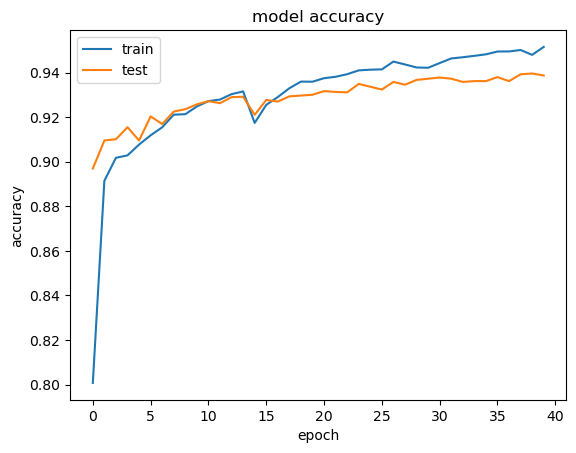

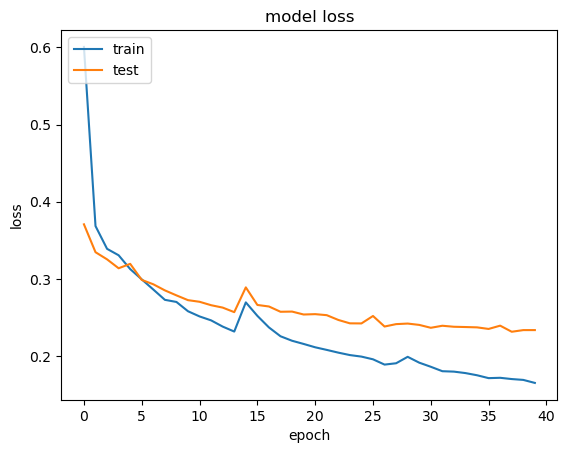

In [40]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [45]:
# test = "Table Lamp with Pull Chain: The USB Bedside Table Lamp comes with a stylish pull chain to control the lamp, you can easy to turn on or turn off the light by pulling the chain, even in the darkness."
# test = "A workwear staple, this men's pocket t-shirt is equal parts durable and comfortable. It has an original fit, Carhartt's roomiest cut. The heavyweight fabric only gets softer with time."
# test = "NEW YORK TIMES BESTSELLER • The epic tale of a woman who breathes a fantastical empire into existence, only to be consumed by it over the centuries—from the transcendent imagination of Booker Prize–winning, internationally bestselling author Salman Rushdie"
test = "Dominate on a different scale with the Razer Huntsman Mini TKL — a 60% gaming keyboard with cutting-edge Razer Clicky Optical Switches. Highly portable and ideal for streamlined setups, it’s time to experience lightning-fast actuation in our most compact form factor yet."

tokens = word_tokenize(test)
# convert to lower case
tokens = [w.lower() for w in tokens]
# remove punctuation from each word    
table = str.maketrans('', '', string.punctuation)
stripped = [w.translate(table) for w in tokens]
# remove remaining tokens that are not alphabetic
words = [word for word in stripped if word.isalpha()]
# filter out stop words    
stop_words = set(stopwords.words('english'))
words = [w for w in words if not w in stop_words]


sequences = tokenizer_obj.texts_to_sequences([words])


review_pad = pad_sequences(sequences, maxlen=max_length)

encoding = ["Books", "Clothing & Accessories", "Electronics", "Household"]
probabilities = ecommerce_model.predict(review_pad)
prediction = np.argmax(probabilities)

print('Sentence being analyzed by the model: ', test)
print(f'Prediction: {encoding[prediction]} with probability {probabilities[0][prediction] * 100}%')

1/1 [==============================] - 0s 70ms/step
Sentence being analyzed by the model:  Dominate on a different scale with the Razer Huntsman Mini TKL — a 60% gaming keyboard with cutting-edge Razer Clicky Optical Switches. Highly portable and ideal for streamlined setups, it’s time to experience lightning-fast actuation in our most compact form factor yet.
Prediction: Electronics with probability 98.27784895896912%
